# Snakemake Introduction to Elephant
## Workflow management based on a electrophysiology example

<table  bgcolor="#000000"><tr>
<td><img src=logos/snakemake_logo.svg alt="Drawing" style="width: 300px;"/>
<td><img src=http://neo.readthedocs.org/en/latest/_images/neologo.png alt="Drawing" style="width: 400px;"/>
<td><img src=http://elephant.readthedocs.org/en/latest/_static/elephant_logo_sidebar.png alt="Drawing" style="width: 400px;"/>
</tr></table>

In this tutorial I will first introduce the workflow management system [snakemake](https://snakemake.readthedocs.io) and show how this can be used for analysis of electrophysiology data using the electrophysiology analysis toolkit [Elephant](http://neuralensemble.org/elephant). For snakemake as well as Elephant tutorials exist already as part of the documentation and were partially reused in the tutorial presented here.

*NOTE: When running this tutorial locally, please first install the [requirements](environment.yml) to ensure the examples are working.*

## Workflow management - Do I need this?

There is a number of reasons for managing your managing workflows besides the classical 'I always run first script a and then script b':
* **Growing Complexity** When starting a seemingly small and simple project everything is still pretty easy, but typically projects tend to grow beyond the initially expected size and complexity. This affects two different aspects 1) the dependency between different steps in workflow as well as 2) the dependency of your analysis results on version of intermediate steps in the pipeline (data as well as code).
* **Collaboration & Sharing** Some day a collegue of yours wants to use your workflow or you are required to publish the analysis together with the manuscript presenting the results of your work to the scientific community. Instead of writing a book about which versions of what programm you installed in which order, wouldn't it be nice to have a structured and self explanatory of your analysis steps already at hand?
* **Software Evolution** Luckily, software develops and bugs are fixed from time to time. Unfortunately this also implies that your workflow might break unexpectedly upon updating your system. Having a well defined environment to run your analysis in is essential for reproducibility of your results.

## Snakemake  <img src=logos/snakemake_logo.svg alt="Drawing" style="width: 100px;"/>

Snakemake helps you to structure your workflow by providing a framework to specify the dependencies between individual steps in your analysis workflow. By doing so it enforces a modular structure in the project and allows to specify the (python) software versions used in each step of the process.

The workflow definition according to snakemake is file based, i.e. each step in the workflow is specified via the required input files and the generated output files, as you might now from common [`Makefiles`](https://en.wikipedia.org/wiki/Make_(software)). Each step is defined in a `rule`, specifying input and output files as well as instructions on how to get from the input to the output files. Here the instructions to convert `fileA.txt` into `fileB.txt` are a simple copy performed in a shell:

In [1]:
%%writefile Snakefile
rule:
    input: 'fileA.txt'
    output: 'fileB.txt'
    shell: 'cp fileA.txt fileB.txt'

Overwriting Snakefile


For snakemake the workflow definition needs to be specified in a `Snakefile` and can be executed by calling `snakemake` in a terminal in the same location as the `Snakefile`. Here the example rule above has been exported into a [`Snakefile`](Snakefile) using the `%%writefile` jupyter magic command.

Now we can ask snakemake to generate `fileB.txt` for us:

In [2]:
%%sh
snakemake

Building DAG of jobs...
MissingInputException in line 1 of /home/julia/presentations/2019-06-20_Toronto/snakemake_elephant_demo/Snakefile:
Missing input files for rule 1:
fileA.txt


CalledProcessError: Command 'b'snakemake\n'' returned non-zero exit status 1.

This fails with snakemake complaining about
```
Missing input files for rule 1:
fileA.txt
```
Which is correct, since there is no `fileA.txt` present to generate `fileB.txt` from. So let's add second rule which is capable of generating `fileA.txt` without required inputfiles.


In [3]:
%%writefile -a Snakefile
rule:
    output: 'fileA.txt'
    shell: 'touch fileA.txt'

Appending to Snakefile


And ask snakemake again to generate the `fileB.txt` for us

In [4]:
%%sh
snakemake

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	1
	1	2
	2

[Sun Jun  9 09:32:18 2019]
rule 2:
    output: fileA.txt
    jobid: 1

[Sun Jun  9 09:32:18 2019]
Finished job 1.
1 of 2 steps (50%) done

[Sun Jun  9 09:32:18 2019]
rule 1:
    input: fileA.txt
    output: fileB.txt
    jobid: 0

[Sun Jun  9 09:32:18 2019]
Finished job 0.
2 of 2 steps (100%) done
Complete log: /home/julia/presentations/2019-06-20_Toronto/snakemake_elephant_demo/.snakemake/log/2019-06-09T093218.538609.snakemake.log


Internally snakemake is first resolving the set of rules into a directed acyclic graph (dag) to determine in which order the rules neet do be executed. We can generate a visualization of the workflow using the `--dag` flag in combination with `dot` and `display` (for local notebook instances) or save the graph as svg (e.g. for remote instances).

In [5]:
%%sh
snakemake --dag | dot | display
snakemake --dag | dot -Tsvg > dag0.svg

Building DAG of jobs...
Building DAG of jobs...


The resulting graph shows the dependencies between the two rules, which were automatically enumerated. The line style (continuous/dashed) indicated whether the rules were already executed or not.

![DAG](dag0.svg)

We can also provide explicit names for rules to make the graph better human readable:

In [6]:
%%writefile Snakefile
rule copy_A_to_B:
    input: 'fileA.txt'
    output: 'fileB.txt'
    shell: 'cp {input} {output}'
rule create_A:
    output: 'fileA.txt'
    shell: 'touch fileA.txt'

Overwriting Snakefile


In [7]:
%%sh
snakemake --dag | dot | display
snakemake --dag | dot -Tsvg > dag1.svg

Building DAG of jobs...
Building DAG of jobs...


![DAG](dag1.svg)

Here we already used a different notation to specify in the shell comand `cp {input} {output}` instead of explicitely repeating the input and output filenames. These placeholders will be substituted by snakemake during the execution by the filenames defined as `input` / `output`. We can use the same notation to generalize the required input of the rule depending on the output, e.g. we permit the copy rule to work for arbitrary files having a certain naming scheme. Here a new folder `new_folder` is automatically generated for the copied files.

In [8]:
%%writefile Snakefile
rule copy_to_new_folder:
    input: 'original_data/file{id}.txt'
    output: 'new_data/file{id}.txt'
    shell: 'cp {input} {output}'
rule create_file:
    output: 'original_data/file{id}.txt'
    shell: 'touch {output}'

Overwriting Snakefile


For running the workflow now, we need to specify, which file we actually need as a final result and snakemake takes care of the individual steps to generate that file. We specify the desired output file as a snakemake argument:

In [9]:
%%sh
snakemake new_data/fileZ.txt --dag | dot | display
snakemake new_data/fileZ.txt --dag | dot -Tsvg > dag2.svg
snakemake new_data/fileZ.txt

Building DAG of jobs...
Building DAG of jobs...
Building DAG of jobs...
Nothing to be done.
Complete log: /home/julia/presentations/2019-06-20_Toronto/snakemake_elephant_demo/.snakemake/log/2019-06-09T093246.182039.snakemake.log


To generate a set of output files, we can either request these individually when running snakemake, e.g. using `snakemake -np new_folder/file{0,1,2,3,4,5,6,7,8,9}.txt`. In case the workflow output is not being changed frequently, it is also possible to add a final rule (conventionally named 'all'), which requests all desired output files of the workflow:

In [10]:
%%writefile Snakefile
rule all:
    input: expand('new_data/file{id}.txt', id=range(10))
rule copy_to_new_folder:
    input: 'original_data/file{id}.txt'
    output: 'new_data/file{id}.txt'
    shell: 'cp {input} {output}'
rule create_file:
    output: 'original_data/file{id}.txt'
    shell: 'touch {output}'

Overwriting Snakefile


In [11]:
%%sh
snakemake --dag | dot | display
snakemake --dag | dot -Tsvg > dag3.svg

Building DAG of jobs...
Building DAG of jobs...


Here I used the snakemake function `expand`, which extends a given statement (here `new_folder_file{id}.txt`) for all combinations of parameters provided (here `id` values from 0 to 10). This permits to easily applied a set of rules to a number of different files.

![DAG](dag3.svg)

Typically, analysis is a bit more complicated than creating empty files and copying them from A to B using shell commands. Snakemake also support a number of different execution methods
* in a shell (as used above)
* in python (using run:)
* run python/R/Markdown scripts directly (using script:)
As an example we can use a small python script to generate our initial data files and store a (randomly generated) value. The Python script would look like this:

In [12]:
%%writefile generate_data.py
import sys
import numpy as np

def generate_random_data(output_filename):
    # write a random number in an output file
    f = open(output_filename, "w")
    f.write(np.random.random())
    f.close()

# extracting the output filename from the command line parameters provided
output_filename = sys.argv[1]
generate_random_data(output_filename)

Overwriting generate_data.py


The corresponding snakemake rule now needs to provide the argument to the `generate_data.py` script:

In [13]:
%%writefile Snakefile
rule all:
    input: expand('new_data/file{id}.txt', id=range(10))
rule copy_to_new_folder:
    input: 'original_data/file{id}.txt'
    output: 'new_data/file{id}.txt'
    shell: 'cp {input} {output}'
rule generate_data:
    output: 'original_data/file{id}.txt'
    run: 'generate_data.py {output}'

Overwriting Snakefile


In [14]:
%%sh
snakemake --dag | dot | display
snakemake --dag | dot -Tsvg > dag4.svg

Building DAG of jobs...
Building DAG of jobs...


Additional features worth having a look at
* conda integration (--use-conda flag)
* test runs (--dryrun)
* print shell commands (-p)
* ...
* [snakemake documentation](https://snakemake.readthedocs.io) and [FAQ](https://snakemake.readthedocs.io/en/stable/project_info/faq.html)

## Utilizing Snakemake for Data Analysis

We will present a simple data analysis workflow based on a published dataset of complex electrophysiology data using the electrophysiology analysis toolkit [Elephant](http://neuralensemble.org/elephant). Elephant is based on the [Neo](https://neo.readthedocs.io) data framework, which will first introduce based on artificially generatey spiking data with a known correlation.

## Neo - the data framework <img src=http://neo.readthedocs.org/en/latest/_images/neologo.png alt="NeoLogo" style="width: 400px;"/>    

![NeoDataModel](https://neo.readthedocs.io/en/0.7.0/_images/base_schematic.png)
*Neo* provides a set of classes for representing time series data (`SpikeTrain`, `AnalogSignalArray`, etc.), for representing the hierarchical arrangement of data in an experiment (`Segment`, `Block`) and for representing the relationship between spike trains and recording channels (`Unit`). Neo is used by a number of data visualization tools ([OpenElectrophy](http://neuralensemble.org/OpenElectrophy), [SpykeViewer](https://spyke-viewer.readthedocs.org/)) and by the [PyNN](http://neuralensemble.org/PyNN) metasimulator. Neo offers reading capabilities for a large number of proprietary electrophysiology data formats and conversion capability to generic open source data formats/models.

The Neo data model consists of container (Block, Segment, ChannelIndex, Unit) and data objects (AnalogSignals, Spiketrains, Epoch, Events). Container objects provide the relation between the data stored in the Neo structure. Here, we consider only Block and Segment objects as containers. Blocks are designed to contain everything related to a whole recording session and link to Segments, which hold data belonging to a common time frame. For data objects we will use SpikeTrains, designed to capture the time series describing the occurrence of spikes together with the corresponding waveforms. All Neo data objects are derivatives of numpy arrays enhanced with the handling of physical quantities, minimal metadata as well as a generic mechanism to add custom metadata.

Performing the analysis requires minimum 3 steps:
* getting / generating the data
* running the main analysis
* generating result plots

Before running the analysis on experimental data, let's generate some data with known ground truth. Here Elephant provides a number of methods to generate spiketrain activity with defined statistical properties. The simplest would be to have independent spike time (Poisson process). Since we later want to detect higher order correlations, we will use a Poisson process as background activity and add correlated spikes to it.

In [20]:
# imports for data handling and visualization
from quantities import Hz, ms
from elephant.spike_train_generation import homogeneous_poisson_process, compound_poisson_process
import neo
import numpy as np
import matplotlib.pyplot as plt

Neo and Elephant are handling physical units consistently during the analysis by using the python module [quantities](https://python-quantities.readthedocs.io). This also requires parameters to be supplied in the correct dimension, such that the physical units can be matched during analysis. In general Neo objects capture all minimal information relevant for the interpretation of the data. In case of the spiketrain, this encompasses the start and stop times of recording/spike extraction as well the sampling_rate and potential custom annotations in form of a dictionary.

In [21]:
spiketrain = homogeneous_poisson_process(20*Hz, 0*ms, 1000*ms)
print('The spiketrain', spiketrain)
print('Spiketrain attributes and physical units')
print(['{}: {}'.format(att, getattr(spiketrain,att)) for att in ['t_start', 't_stop', 'sampling_rate', 'annotations']])
print(['{}: {}'.format(att, getattr(spiketrain,att).units.dimensionality) for att in ['t_start', 't_stop', 'sampling_rate']])

The spiketrain [ 36.93074588  61.6662392   88.98177318 130.79297446 162.72648138
 214.97093946 281.5373308  299.02891039 443.91821042 446.421389
 470.33935321 517.56473044 718.32428799 762.97998738 796.33587736
 881.82476674 924.69677941] ms
Spiketrain attributes and physical units
['t_start: 0.0', 't_stop: 1000.0', 'sampling_rate: 1.0', 'annotations: {}']
['t_start: ms', 't_stop: ms', 'sampling_rate: Hz']


An a first rule in or new workflow, let's generate multiple datasets with spiking activity and save them for future analysis steps. From the variety of file formats supported by Neo NIX has an hdf5 backend. Let's implement a virtual expiment, generating 100 poisson spiketrains stored in the NIX framework:

In [27]:
def generate_poisson_data(output_filename):
    io = neo.io.AsciiSpikeTrainIO(output_filename)
    segment = neo.Segment(name='trial 0')
    segment.spiketrains.append(homogeneous_poisson_process(20*Hz, 0*ms, 1000*ms))
    io.write_segment(segment)
    
generate_poisson_data('original_data/example_spiketrain.txt')

We export this piece of code into a standalone script so we can use it in the snakemake workflow:

In [28]:
%%writefile generate_poisson.py
import sys
import neo
from os.path import join
from quantities import Hz, ms
from elephant.spike_train_generation import homogeneous_poisson_process
def generate_poisson_data(output_folder, n=10):
    for i in range(n):
        io = neo.io.AsciiSpikeTrainIO('{}/spiketrain-{}.txt'.format(output_folder, i))
        segment = neo.Segment()
        segment.spiketrains = [homogeneous_poisson_process(20*Hz, 0*ms, 1000*ms).rescale('s')]
        io.write_segment(segment)
    
if __name__=='__main__':
    generate_poisson_data(*sys.argv[1:])

Overwriting generate_poisson.py


In [30]:
from generate_poisson import generate_poisson_data
from os import mkdir
mkdir('original_data/dataset6')
generate_poisson_data('original_data/dataset6')

The first rule in the workflow know how to utilize the script to generate new datasets:

In [31]:
%%writefile Snakefile
wildcard_constraints:
    id="\d+"

rule all:
    input: expand('original_data/dataset{id}/spiketrain-{i}.txt', id=range(10), i=range(10))
        
rule generate_data:
    output: expand('original_data/dataset{{id}}/spiketrain-{i}.txt', i=range(10))
    params: dir_name='original_data/dataset{id}'
    shell: 'python generate_poisson.py {params.dir_name}'

Overwriting Snakefile


And running the workflow. The output files should appear [here](original_data).

In [32]:
%%sh
snakemake -pr

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	all
	9	generate_data
	10

[Sun Jun  9 09:53:34 2019]
rule generate_data:
    output: original_data/dataset3/spiketrain-0.txt, original_data/dataset3/spiketrain-1.txt, original_data/dataset3/spiketrain-2.txt, original_data/dataset3/spiketrain-3.txt, original_data/dataset3/spiketrain-4.txt, original_data/dataset3/spiketrain-5.txt, original_data/dataset3/spiketrain-6.txt, original_data/dataset3/spiketrain-7.txt, original_data/dataset3/spiketrain-8.txt, original_data/dataset3/spiketrain-9.txt
    jobid: 4
    reason: Missing output files: original_data/dataset3/spiketrain-0.txt, original_data/dataset3/spiketrain-5.txt, original_data/dataset3/spiketrain-7.txt, original_data/dataset3/spiketrain-8.txt, original_data/dataset3/spiketrain-9.txt, original_data/dataset3/spiketrain-3.txt, original_data/dataset3/spiketrain-1.txt, original_data/dataset3/spiketra

In [33]:
%%sh
snakemake --dag | dot | display
snakemake --dag | dot -Tsvg > dag5.svg

Building DAG of jobs...
Building DAG of jobs...


To visualize the generated data, we implement a utility script to load the data and a second script plot the data using matplotlib.

In [2]:
%%writefile load_data.py
from os.path import isdir
import glob
import neo
def load_data_segment(data_location):
    print(data_location)
    if isdir(data_location):
        # return assembled spiketrains from ascii files
        segment = neo.Segment()
        data_files = glob.glob('{}/*.txt'.format(data_location))
        for filename in data_files:
            io = neo.io.AsciiSpikeTrainIO(filename)
            segment.spiketrains.extend(io.read_segment().spiketrains)
        segment.annotate(data_sources=data_files)
        return segment
    else:
        # return first segment of recording for all other supported formats
        io = neo.io.get_io(data_location)
        return io.read_block().segments[0]

Overwriting load_data.py


In [35]:
%%writefile plot_original_data.py
import sys
import neo
import matplotlib.pyplot as plt
from load_data import load_data_segment
def plot_original_data(data_filename, plot_filename):
    segment = load_data_segment(data_filename)
    for i, spiketrain in enumerate(segment.spiketrains):
        plt.plot(spiketrain, [i]*len(spiketrain), '.')
    plt.xlabel('Time [{}]'.format(spiketrain[0].units.dimensionality.latex))
    plt.ylabel('Spiketrains')
    plt.savefig(plot_filename)
    
if __name__=='__main__':
    plot_original_data(*sys.argv[1:])

Overwriting plot_original_data.py


original_data/dataset1


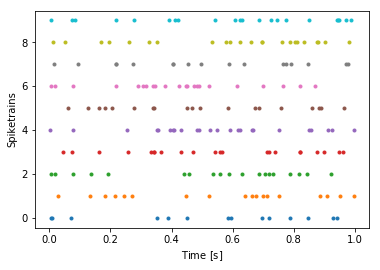

In [36]:
from plot_original_data import plot_original_data
plot_original_data('original_data/dataset1', 'original_data/dataset1/spiketrains.png')

In [37]:
%%writefile -a Snakefile

rule plot_data:
    input: '{folder}/dataset{id}'
    output: '{folder}/dataset{id}/spiketrains.png'
    run: 'plot_original_data.py {input} {output}'

Appending to Snakefile


In [38]:
%%sh
snakemake original_data/dataset0/spiketrains.png --dag | dot | display

Building DAG of jobs...


In the next step we want to run an analysis on the data, which is detecting the injected higher order correlation ins the data. One of the methods suited for the detection of spatio-temporal patterns is `SPADE` [(Quaglio et al, 2017)](https://doi.org/10.3389/fncom.2017.00041)
.

In [75]:
import elephant.spade

In [3]:
import sys
from load_data import load_data_segment
import quantities as pq

def run_spade(dataset, output_folder):
    sts = load_data_segment(dataset).spiketrains
    # normalize spike time ranges
    for st in sts:
        st.t_stop = max([st.t_stop for st in sts])
    # run spade analysis
    patterns = elephant.spade.spade(
        data=sts, binsize=1*pq.ms, winlen=1, dither=5*pq.ms,
        min_spikes=3, n_surr=10, psr_param=[0,0,3],
        output_format='patterns')['patterns']
    # save patterns
    for i, pattern in enumerate(patterns):
        neurons = pattern['neurons']
        io = neo.io.AsciiSpikeTrainIO('{}/pattern-{}-neurons-{}.txt'.format(output_folder,i, '-'.join(neurons)))
        segment = neo.Segment()
        segment.spiketrains = [neo.SpikeTrain(pattern['times']*pq.s, t_start)]
        io.write_segment()

if __name__=='__main__':
    run_spade(*sys.argv[1:])

-f


OSError: File extension  not registered

In [82]:
plot_pattern=patterns[0]

plt.figure()


# Raster plot of the data
for st_idx, st in enumerate(sts):
    if st_idx == 0:
        plt.plot(st.rescale(pq.ms), [st_idx] * len(st), 'k.', label='spikes')
    else:
        plt.plot(st.rescale(pq.ms), [st_idx] * len(st), 'k.')
        
labeled=False
for neu in plot_pattern['neurons']:
    if labeled == False:
        plt.plot(
            plot_pattern['times'], [neu]*len(plot_pattern['times']), 'ro', label='pattern')
        labeled=True
    else:
        plt.plot(
            plot_pattern['times'], [neu] * len(plot_pattern['times']), 'ro')
plt.ylim([-1, len(sts)])
plt.xlabel('time (ms)')
plt.ylabel('neurons ids')
plt.yticks(range(0,100,10))
plt.legend()
plt.show()

IndexError: list index out of range

Downloading publicly available dataset

In [45]:
%%writefile -a Snakefile

rule download_data:
    output: 'original_data/dataset10/spiketrains.nev'
    params: 'original_data/dataset10'
    shell: 'wget -o {output} https://web.gin.g-node.org/INT/multielectrode_grasp/raw/24cd5caee3ae79066ca37844cab931d04dcad977/datasets/i140703-001.nev'

Appending to Snakefile


In [53]:
%%sh
snakemake original_data/dataset10/spiketrains.nev

Building DAG of jobs...


In [ ]:
# TODOs:
* get data from gin
* run spade on nev files

In [ ]:
        for i, spiketrain in enumerate(spiketrains):
            plt.plot(spiketrain, [i] * len(spiketrain), '.')
plt.xlabel('Time ({})'.format(spiketrains[0].times.dimensionality.latex))
plt.ylabel('Spiketrains')

Here, all spiketimes are uncorrelated, which would make this dataset a bit boring for analysis. To introduce some correlations, while keeping all other aspects constant Elephant provides the option to generate a compound poisson process

In [ ]:
sts = compound_poisson_process(rate=5*pq.Hz, A=[0]+[0.99]+[0]*9+[0.01], t_stop=10*pq.s)
for i in range(89):
    sts.append(homogeneous_poisson_process(rate=5*pq.Hz, t_stop=10*pq.s))

*Elephant* is a data analysis library built on Neo. It aims to provide a standard library for electrophysiology data analysis, merging functions from OpenElectrophy, SpykeViewer and [NeuroTools](http://neuralensemble.org/NeuroTools).

In [ ]:
TOADD
SNAKEMAKE
* wildcards (done)
* different rule execution statements (done)
* conda environments
* expand (done)
* config
* rulegraph
NEO
* class structure
* io overview
* intro to main data objects
ELEPHANT
* spade elephant demo